In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load dataset
PATH = 'Dataset'
image_size = (128, 128)
batch_size = 32

data = image_dataset_from_directory(PATH,
                                    batch_size=batch_size,
                                    image_size=image_size,
                                    shuffle=True,
                                    seed=42)

class_names = data.class_names

Found 6400 files belonging to 4 classes.


In [4]:
# Set visualization parameters
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

# Define the image_counter function to count the images in each class directory
def image_counter(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')])
    return class_counts

# Define a function to plot class distribution
def plot_class_distribution(class_dist):
    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)
    
    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]
    
    plt.pie(values, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors, textprops={'fontsize': 12, "fontweight" : "bold", "color":"darkblue"},  wedgeprops=
           {'edgecolor':'darkblue'} , labeldistance=1.15)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold")
    plt.show()

# Define a function to visualize samples
def visualize_samples(class_path, num_samples=5):
    image_files = [image for image in os.listdir(class_path) if image.endswith('.jpg')]

    fig, ax = plt.subplots(1, num_samples, facecolor="gray")
    fig.suptitle(f'{os.path.basename(class_path)} Brain MRI Samples', color="yellow", fontsize=16, fontweight='bold', y=0.75)
    
    for i in range(num_samples):
        image_path = os.path.join(class_path, image_files[i])
        img = mpimg.imread(image_path)

        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(f'Sample {i+1}', color="aqua")

    plt.tight_layout()
    plt.show()

# Define a function to visualize a batch of images
def visualize_batch_images(batch, number_of_images=5, class_names=None):
    fig, ax = plt.subplots(ncols=number_of_images, figsize=(20, 20), facecolor="gray")
    fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="yellow", fontsize=18, fontweight='bold', y=0.6)
    for idx, img in enumerate(batch[0][:number_of_images]):
        ax[idx].imshow(img)
        class_no = batch[1][idx]
        ax[idx].set_title(class_names[class_no], color="aqua")
        ax[idx].set_xticklabels([])
        ax[idx].set_yticklabels([])
    plt.show()

# Define a function to check data imbalance
def check_data_imbalance(data, class_names):
    class_counts = {}
    
    for _, labels in data:
        labels = labels.numpy()
        for label in labels:
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes', fontsize=14)
    plt.ylabel('Number of samples', fontsize=14)
    plt.title('Class Distribution', fontsize=16)
    plt.xticks(classes, class_names)
    plt.show()

    return class_counts

# Define a function to compute class weights
def compute_class_weights(data):
    labels = []

    for _, label_batch in data:
        labels.extend(label_batch.numpy())

    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    return dict(zip(np.unique(labels), class_weights))

# Define callbacks for model training
def create_callbacks():
    checkpoint_filepath = '/tmp/checkpoint.keras'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_freq='epoch',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    es_callback = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1
    )
    return [model_checkpoint_callback, es_callback]

# Intensity normalization function
def normalize_intensity(image):
    return tf.image.per_image_standardization(image)

# Spatial smoothing function
def smooth_image(image, sigma=1):
    # Gaussian smoothing
    return tf.image.adjust_brightness(image, delta=0.1) # Adjust brightness as a placeholder



In [5]:
# Load dataset
PATH = 'Dataset'
data = tf.keras.utils.image_dataset_from_directory(PATH,
                                                batch_size=32,
                                                image_size=(128, 128),
                                                shuffle=True,
                                                seed=42)

Found 6400 files belonging to 4 classes.


In [6]:
# Preprocessing function
@tf.function
def preprocess_image(image):
    image = normalize_intensity(image)
    image = smooth_image(image)
    identity_matrix = np.eye(image.shape[-1])
    return image

# Normalize, smooth, and register images
def preprocess_dataset(data):
    def preprocess_batch(images, labels):
        images = tf.map_fn(preprocess_image, images, fn_output_signature=tf.float32)
        return images, labels
    
    return data.map(preprocess_batch)

data = preprocess_dataset(data)


In [7]:
# Prepare data
def preprocess_images(data):
    images = []
    labels = []
    
    for batch in data:
        for img, label in zip(batch[0], batch[1]):
            img_resized = tf.image.resize(img, [64, 64]).numpy()
            img_flattened = img_resized.flatten()
            images.append(img_flattened)
            labels.append(label.numpy())
    
    return np.array(images), np.array(labels)

X, y = preprocess_images(data)

In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Compute class weights
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weight))

In [10]:
# Function to train and evaluate SVM models
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, strategy):
    if strategy == 'OvR':
        model = SVC(decision_function_shape='ovr', kernel='linear', class_weight=class_weights, probability=True, random_state=42)
    elif strategy == 'OvO':
        model = SVC(decision_function_shape='ovo', kernel='linear', class_weight=class_weights, probability=True, random_state=42)
    elif strategy == 'Direct':
        model = SVC(kernel='linear', class_weight=class_weights, probability=True, random_state=42)
    else:
        raise ValueError("Unsupported strategy. Choose 'OvR', 'OvO', or 'Direct'.")
    
    model.fit(X_train, y_train)
    
    # Predictions and evaluation
    y_pred = model.predict(X_test)
    print(f"Classification Report for {strategy}:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10,6), dpi=300)
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f")
    plt.title(f"Confusion Matrix ({strategy})", fontweight="bold")
    plt.xlabel("Predicted", fontweight="bold")
    plt.ylabel("True", fontweight="bold")
    plt.show()
    return model

Classification Report for Direct:
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.99      0.97       179
 Moderate_Demented       1.00      1.00      1.00        13
      Non_Demented       0.98      0.98      0.98       640
Very_Mild_Demented       0.98      0.98      0.98       448

          accuracy                           0.98      1280
         macro avg       0.98      0.99      0.98      1280
      weighted avg       0.98      0.98      0.98      1280



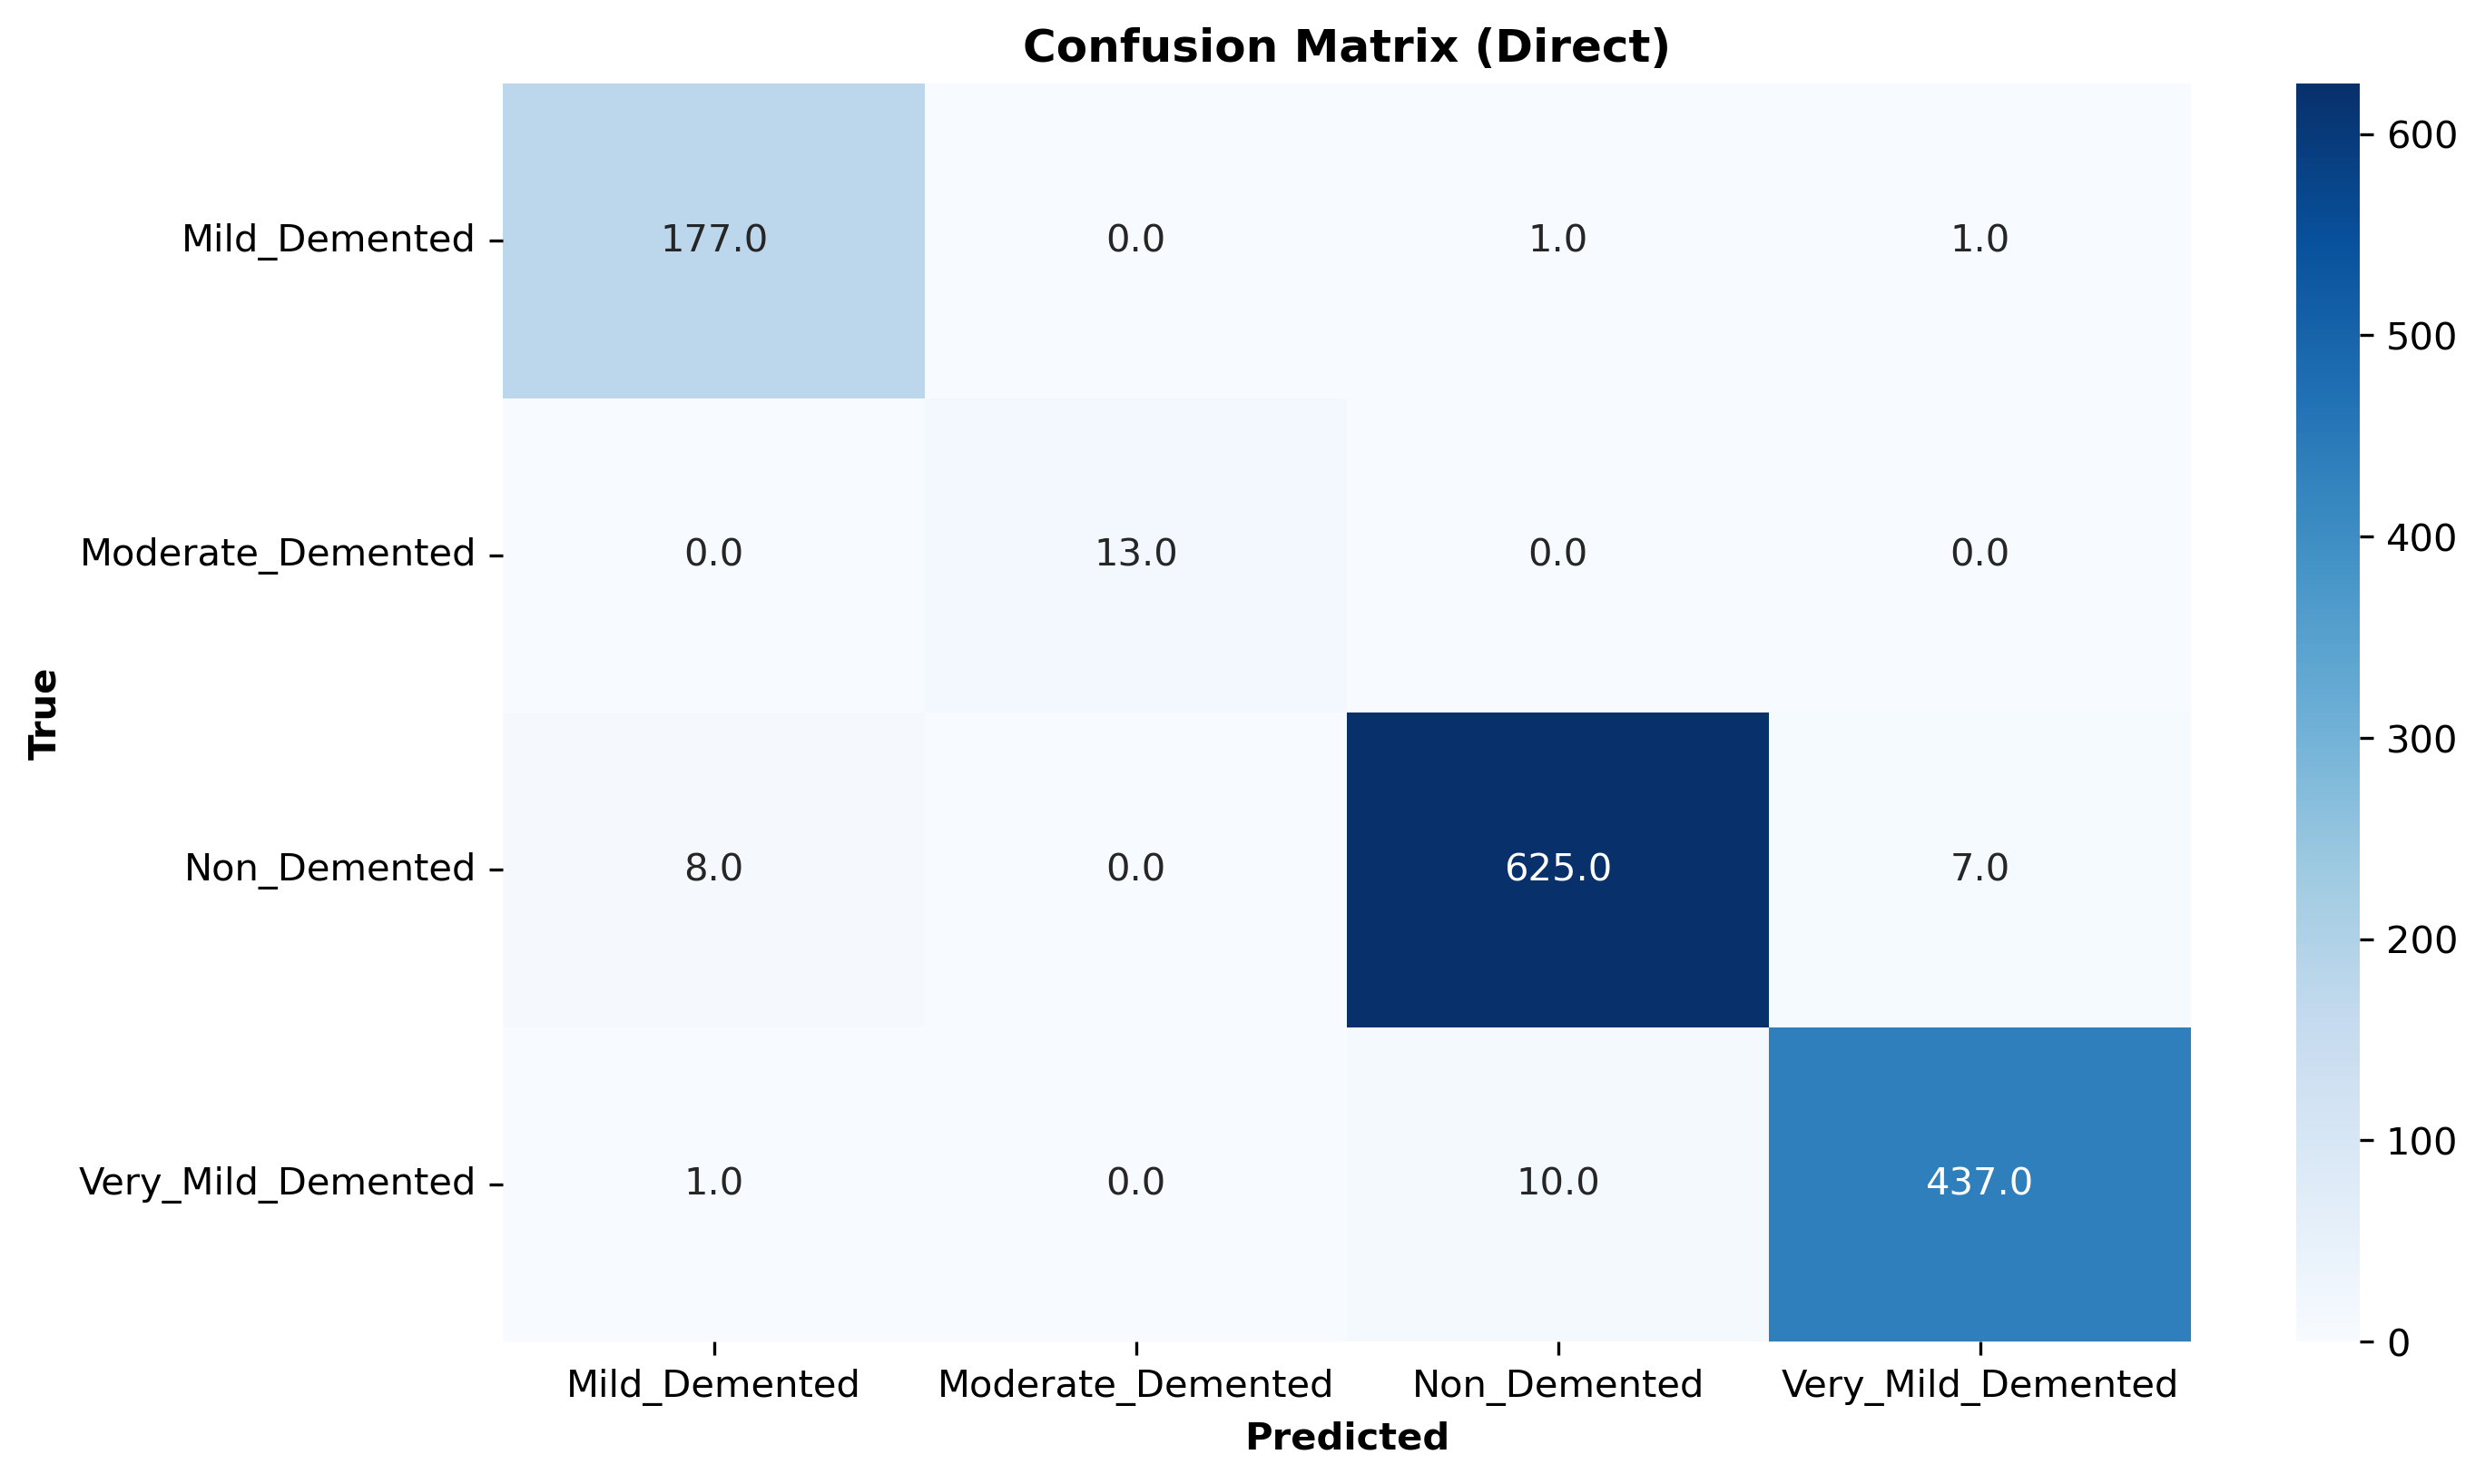

In [11]:
# Train and evaluate models with different strategies
strategies = ['Direct','OvR', 'OvO']
SVM_Direct_Model = train_and_evaluate_svm(X_train, X_test, y_train, y_test, strategies[0])

In [13]:
import joblib
joblib.dump(SVM_Direct_Model, 'SVM_Direct_Model_New.pkl')

['SVM_Direct_Model_New.pkl']

Classification Report for OvR:
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.99      0.97       179
 Moderate_Demented       1.00      1.00      1.00        13
      Non_Demented       0.98      0.98      0.98       640
Very_Mild_Demented       0.98      0.98      0.98       448

          accuracy                           0.98      1280
         macro avg       0.98      0.99      0.98      1280
      weighted avg       0.98      0.98      0.98      1280



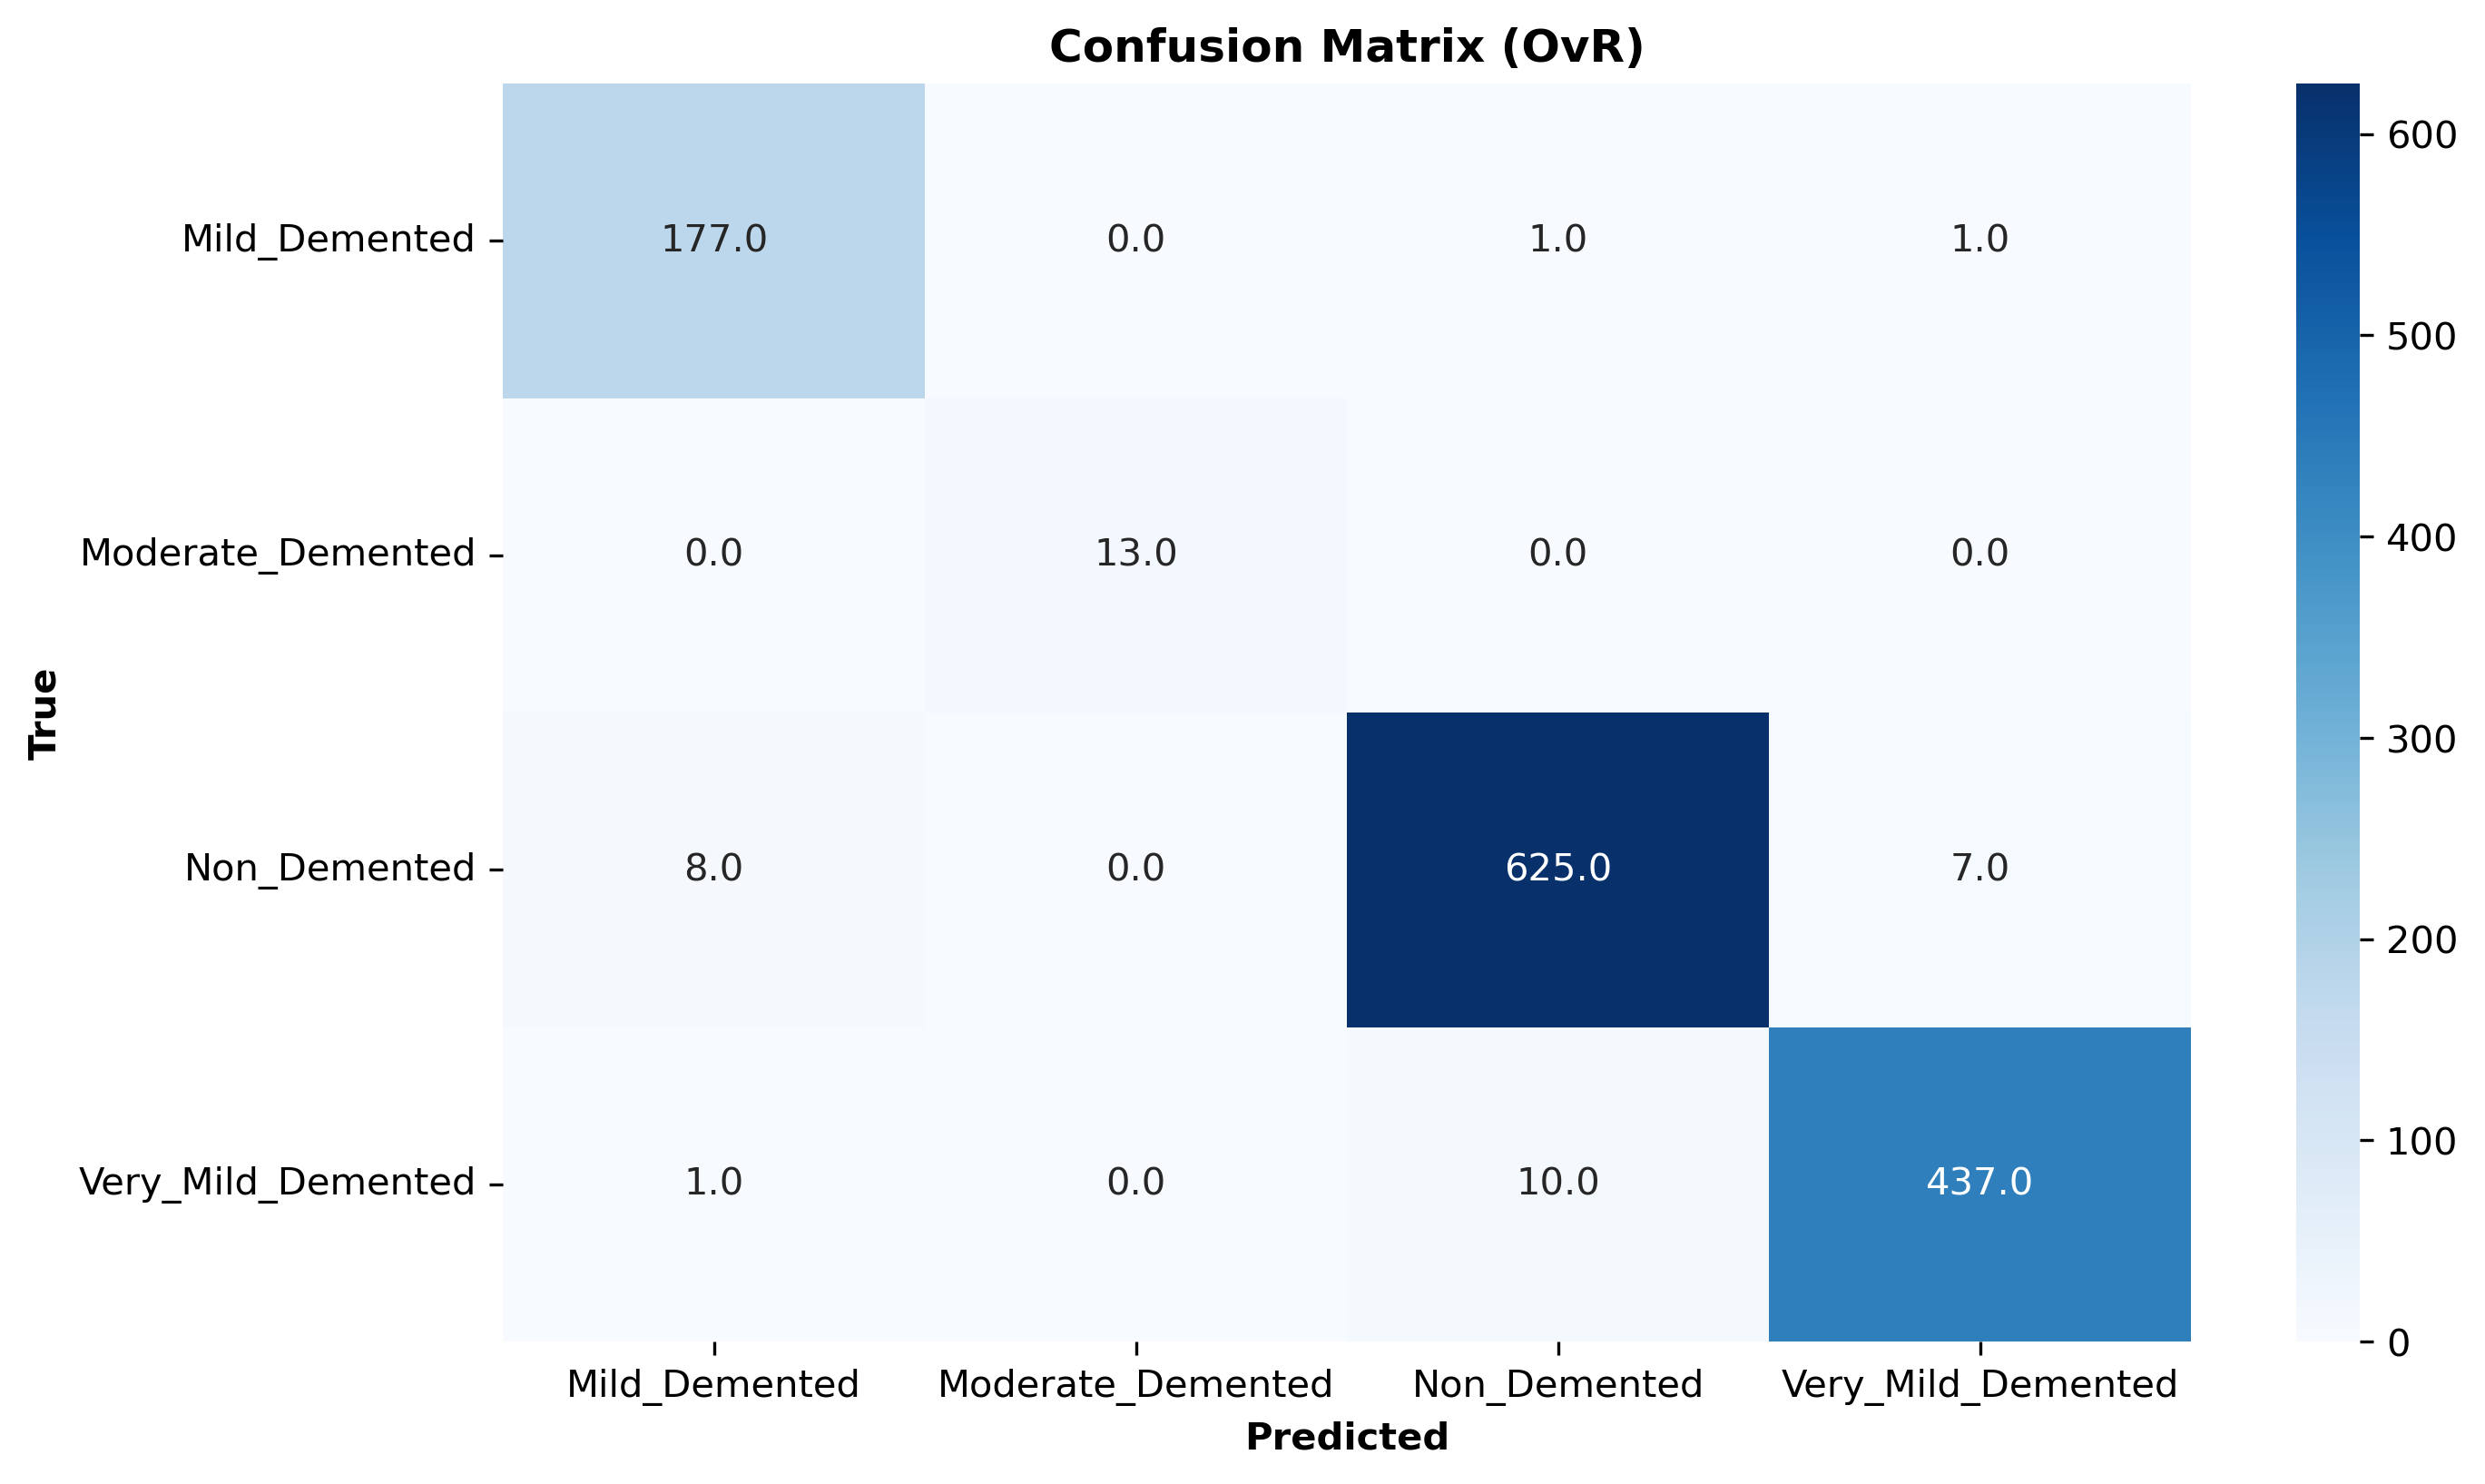

In [14]:
SVM_OVR_Model = train_and_evaluate_svm(X_train, X_test, y_train, y_test, strategies[1])

Classification Report for OvO:
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.99      0.97       179
 Moderate_Demented       1.00      1.00      1.00        13
      Non_Demented       0.98      0.98      0.98       640
Very_Mild_Demented       0.98      0.98      0.98       448

          accuracy                           0.98      1280
         macro avg       0.98      0.99      0.98      1280
      weighted avg       0.98      0.98      0.98      1280



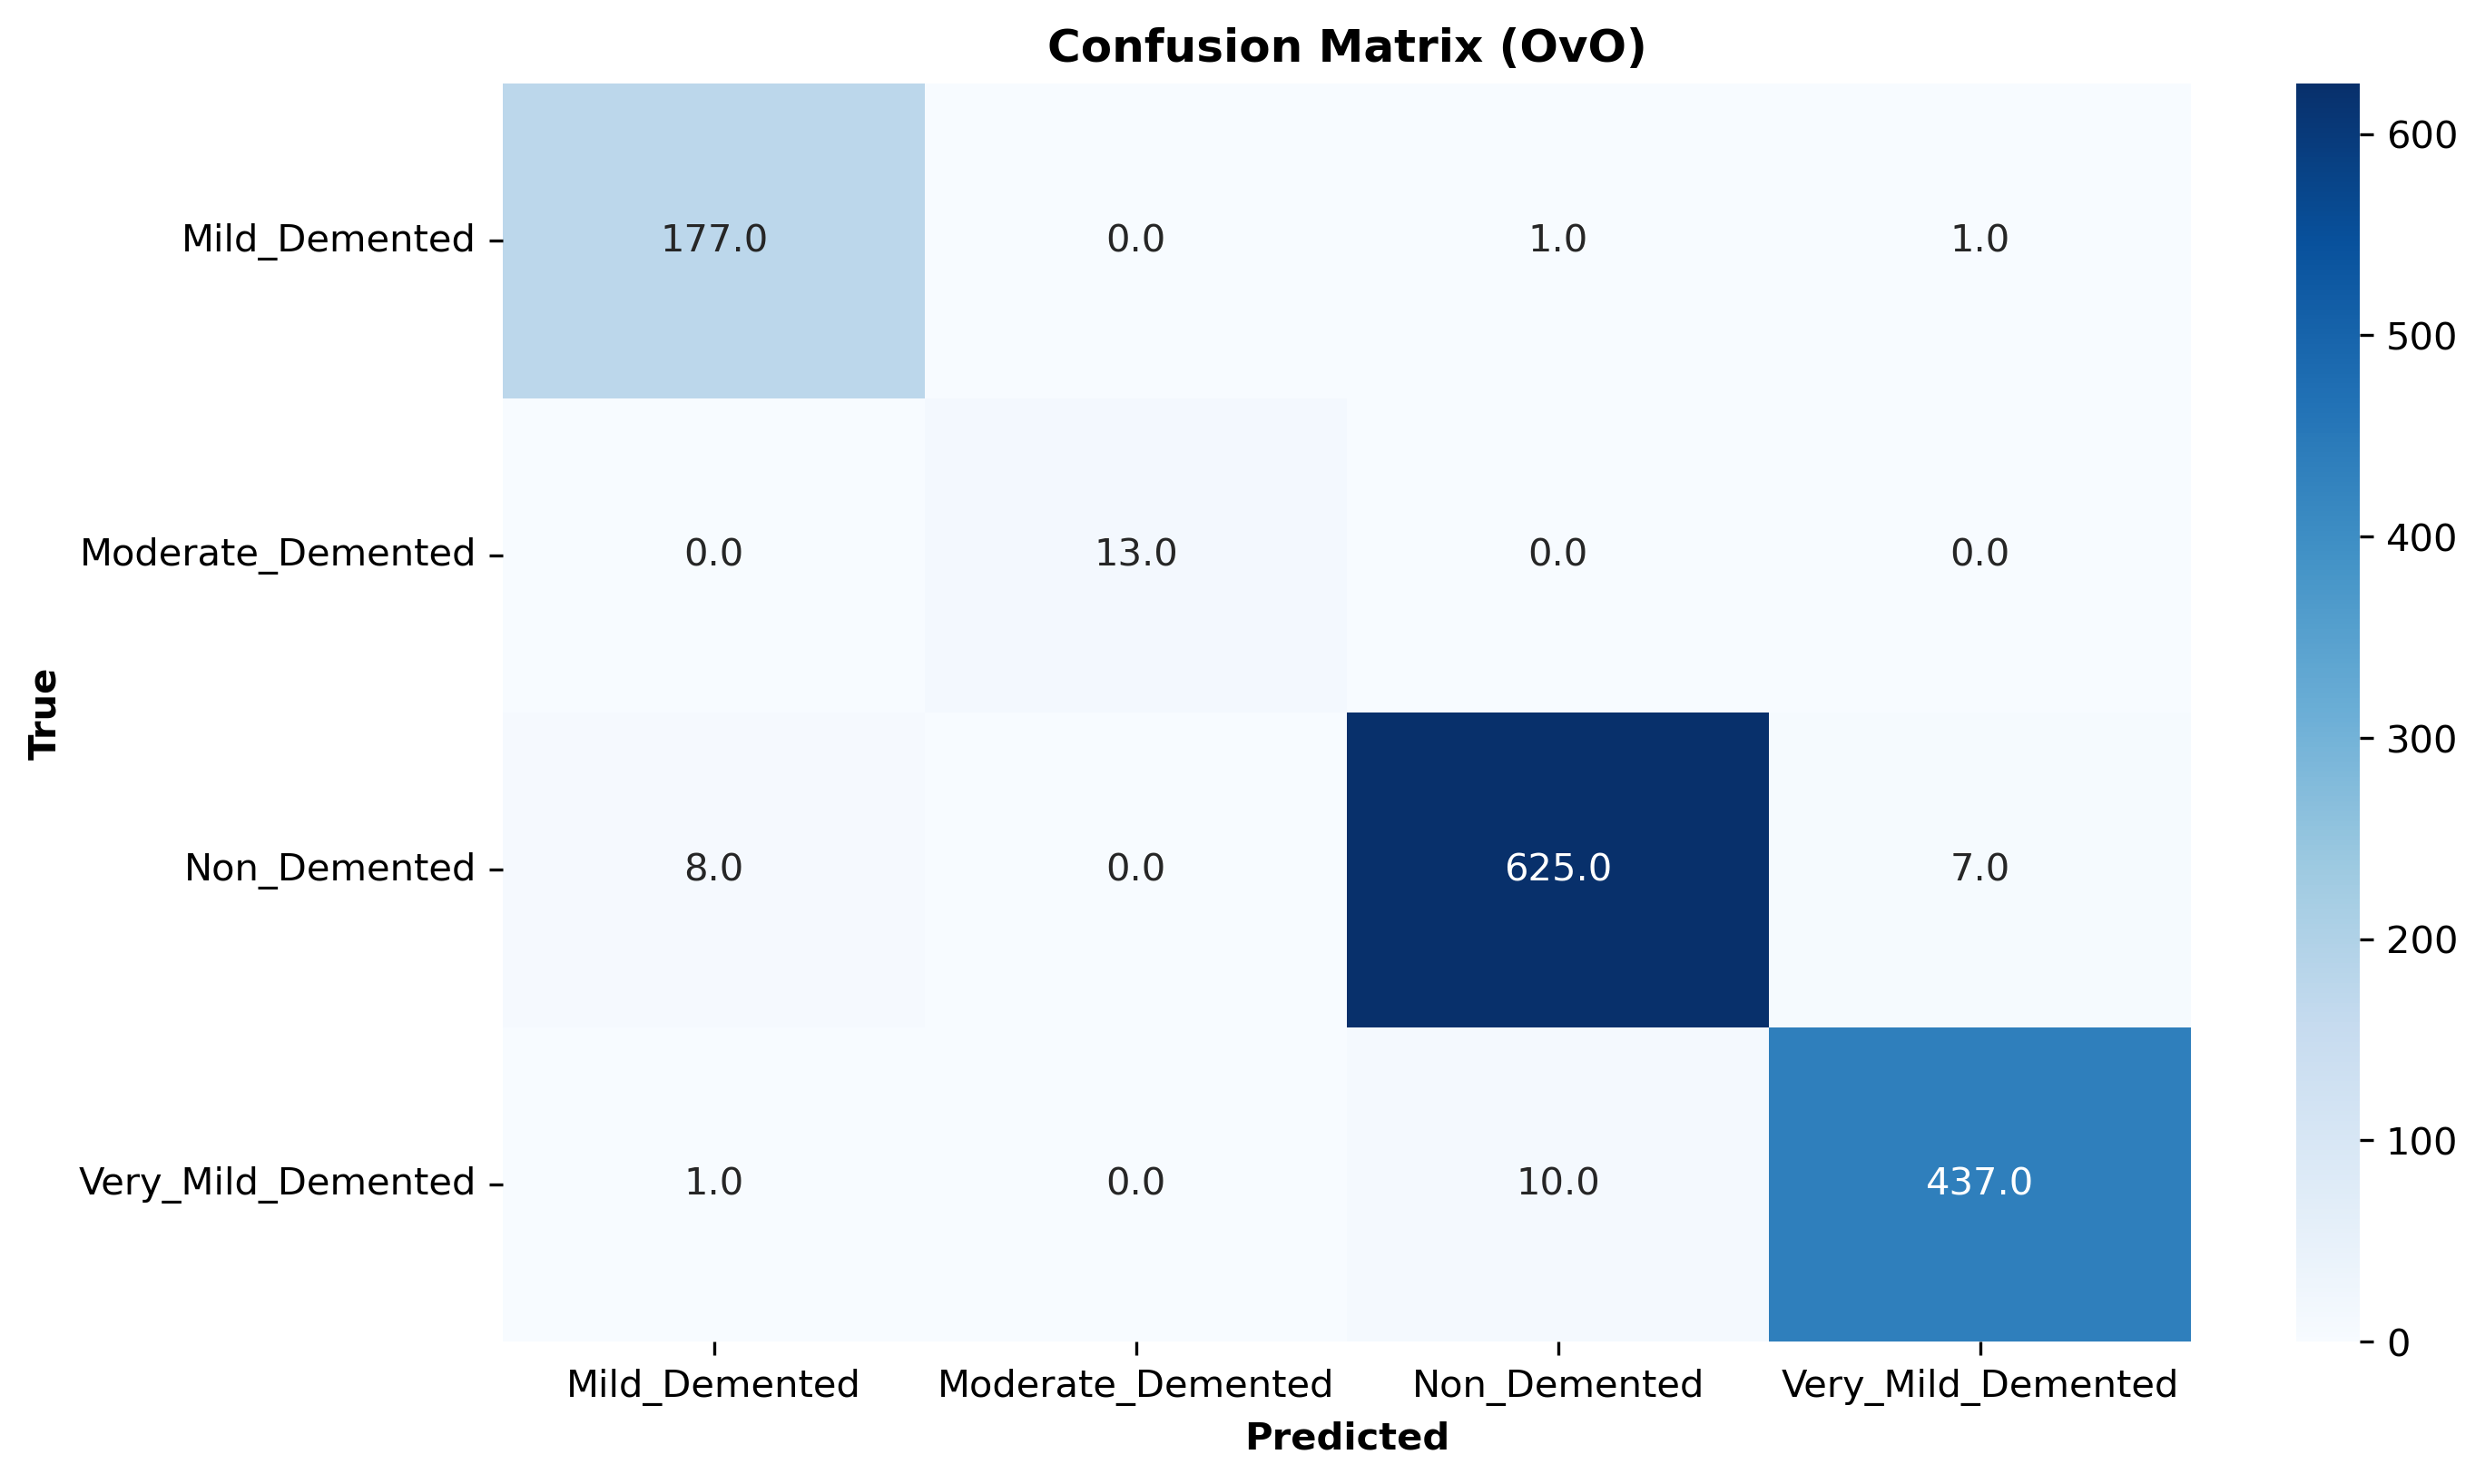

In [15]:
SVM_OvO_Model = train_and_evaluate_svm(X_train, X_test, y_train, y_test, strategies[2])

In [17]:
print("Size of y_test:", len(y_test))
print("Size of y_pred:", len(X_test))

Size of y_test: 1280
Size of y_pred: 1280


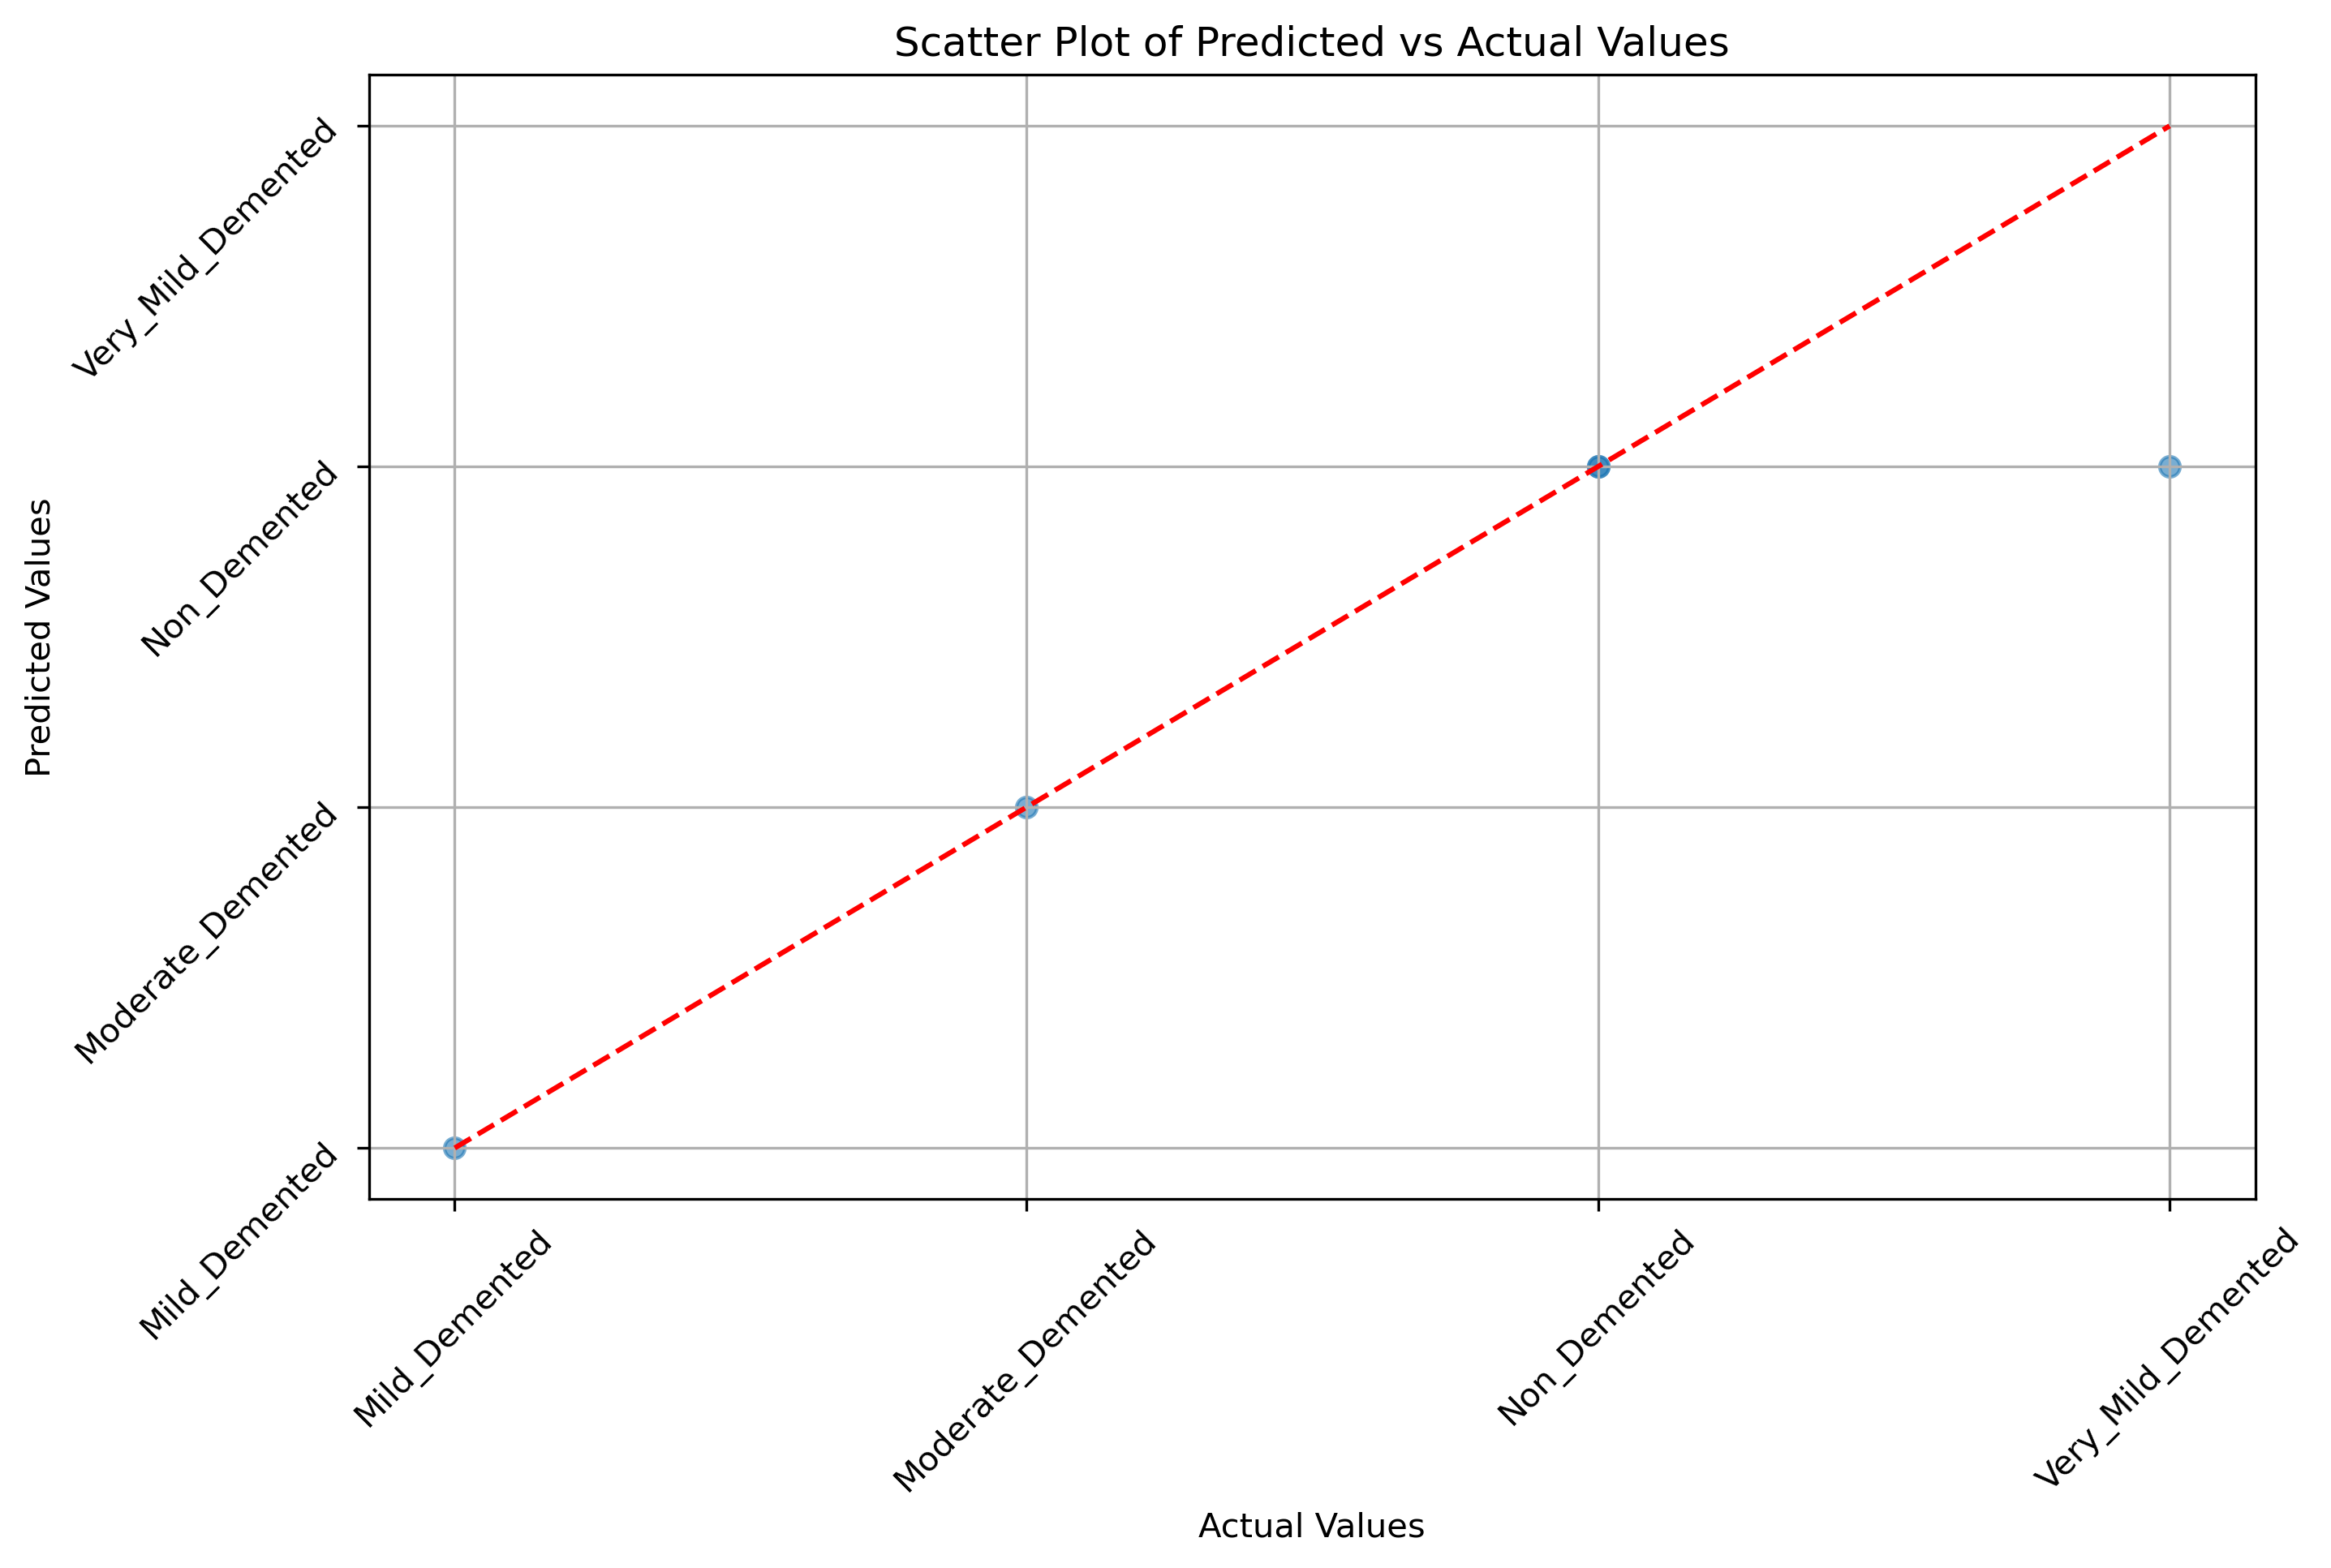

In [18]:
def plot_predicted_vs_actual(y_test, y_pred, class_names):
    # Convert labels to numerical indices
    y_test_indices = [class_names.index(label) for label in y_test]
    y_pred_indices = [class_names.index(label) for label in y_pred]
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(y_test_indices, y_pred_indices, alpha=0.6)
    
    # Adding a line for perfect predictions
    plt.plot([min(y_test_indices), max(y_test_indices)], [min(y_test_indices), max(y_test_indices)], color='red', linestyle='--')
    
    # Labeling
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of Predicted vs Actual Values')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.yticks(range(len(class_names)), class_names, rotation=45)
    
    plt.grid(True)
    plt.show()

class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
y_test = ['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Non_Demented']
y_pred = ['Mild_Demented', 'Non_Demented', 'Non_Demented', 'Moderate_Demented', 'Non_Demented']
plot_predicted_vs_actual(y_test, y_pred, class_names)